# Leakage Detection Algorithm Approximation
## by Ida & Benjamin for the course Deep Learning

In this notebook we will go through the workflow for the best performing model; the stacked CNN, LSTM and Dense layers.

First, we load our dependencies:

In [2]:
import numpy as np
import torch
import dataloader2
from torch.utils import data
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu

The data we are given are hourly measurements of the output of a water supply, along with daily targets indicating if a leakage is detected or not. There are a lot of missing datapoints in the data that need to be dealed with, besides that, our data need to be converted to a format that is usefull for our models. Besides this, we also sort in our data to only consider the same things as the algorithm we are trying to approximate does. All these things is done in our dataloader:

In [4]:
inputs_train, targets_train, inputs_val, targets_val, inputs_test, targets_test = dataloader2.data_prep(
                                                                                            path='Fruedal data.xlsx',
                                                                                            day='weekday',
                                                                                            start_time=1,
                                                                                            end_time=6,
                                                                                            num_days_seq = 50,
                                                                                            t_train=0.4,
                                                                                            t_test=0.6,
                                                                                            clean=True)


We load or data in a Dataset class and then we use a pytorch dataloader to prepare for training:

In [6]:
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

training_set = Dataset(np.array(inputs_train), np.array(targets_train))
validation_set = Dataset(np.array(inputs_val), np.array(targets_val))
test_set = Dataset(np.array(inputs_test), np.array(targets_test))

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

trainloader = torch.utils.data.DataLoader(training_set, batch_size=50,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(validation_set, batch_size=50,
                                         shuffle=True)

We have 317 samples in the training set.
We have 476 samples in the validation set.
We have 0 samples in the test set.


We prepare for GPU use:

In [7]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

The best performing model was found to be defined as follows:

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        

        self.dropout = nn.Dropout(p=0.5)

        self.conv1 = nn.Conv1d(in_channels = 1,
                               out_channels = 10,
                               kernel_size = 15,
                               stride = 1)
        
        self.pool1 = nn.MaxPool1d(4, stride = 2)
        
        self.bn1 = nn.BatchNorm1d(10)
        
        self.lstm = nn.LSTM(input_size = 10, hidden_size = 8, num_layers = 2, bias=True, dropout=0.5)
        
        self.l_out = nn.Linear(in_features=8,
                            out_features=1,
                            bias=False)
        
    def forward(self, x):

        # Output layer
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = relu(x)
        x = self.pool1(x) 
        x = x.permute(2,0,1)        
        x, (h, c) = self.lstm(x)
        x = h[1].view(-1, 8)
        x = relu(x)
        x = self.l_out(x)
        x = torch.sigmoid(x)
        return x

The training was done in the following way. We are not interested in retraining model, also since this will yield a different result because of the initialization.

In [13]:
train_model = False

net = Net()
if use_cuda:
    net.cuda()


criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002, weight_decay=0.001)

num_epoch = 4000

# Track loss
training_loss, validation_loss = [], []

if train_model:

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        epoch_training_loss = 0
        epoch_validation_loss = 0

        net.eval()

        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data

            inputs.unsqueeze_(0)
            inputs = inputs.permute(1,0,2)
            # wrap them in Variable
            inputs, labels = get_variable(Variable(inputs)), get_variable(Variable(labels))



            outputs = net(inputs)
            loss = criterion(outputs, labels)

            epoch_validation_loss += loss.cpu().detach().numpy()

        net.train()

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            inputs.unsqueeze_(0)
            inputs = inputs.permute(1,0,2)

            # wrap them in Variable
            inputs, labels = get_variable(Variable(inputs)), get_variable(Variable(labels))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_training_loss += loss.cpu().detach().numpy()

        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

    print('Finished Training')
    
else:
    net = torch.load('Models/CNNLSTM.ph')

C:\Program Files (x86)\Anaconda\lib\site-packages\torch\serialization.py:419: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


We look at the convergence by looking at the accuracy on the training and test data during training.

In [ ]:
net.eval()
# Plot training and validation loss
if train_model:
    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('NLL')
    plt.show()

Lets have a look at the models performance on the train and test data:

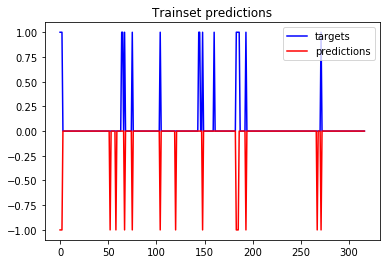

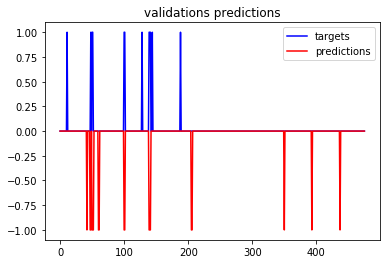

In [16]:
n = inputs_train.shape[0]
outputs = np.zeros(n)
net = net.cpu()
for i in range(n):
    inputs = torch.Tensor(inputs_train[i].reshape(1,-1))
    inputs.unsqueeze_(0)
    inputs = inputs.permute(1,0,2)
    outputs[i] = net.forward(inputs).data.numpy()
 
outputs = np.round(-outputs)

plt.figure()
plt.title('Trainset predictions')
plt.plot(targets_train[:n], 'b-')
plt.plot(outputs, 'r-')
plt.legend(['targets',  'predictions'])
plt.show()

n = inputs_val.shape[0]
outputs = np.zeros(n)
for i in range(n):
    inputs = torch.Tensor(inputs_val[i].reshape(1,-1))
    inputs.unsqueeze_(0)
    inputs = inputs.permute(1,0,2)
    outputs[i] = net.forward(inputs).data.numpy()
 
outputs = np.round(-outputs)

plt.figure()
plt.title('validations predictions')
plt.plot(targets_val[:n], 'b-')
plt.plot(outputs, 'r-')
plt.legend(['targets',  'predictions'])
plt.show()